In [35]:
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/12/ff/a04156f4ca3d18bd005c73f79e86e0684346fbc2aea856429c3e49f2828e/prophet-1.1.6-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/2a/80/04b3989f055e555737b3b6944f02112e90cfc4f2e53c763771dded22e684/cmdstanpy-1.2.5-py3-none-any.whl.metadata
  Obtaining dependency information for holidays<1,>=0.25 from https://files.pythonhosted.org/packages/47/03/f92e1a10429c6d833b51841c9c9ba37721aac0097b0a9d2f83808fcf64e8/holidays-0.70-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-resources from https://files.pythonhosted.org/packages/a4/ed/1f1afb2e9e7f38a545d628f864d562a5ae64fe6f7a10e28ffb9b185b4e89/importlib_resources-6.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://fi

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import joblib
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose

In [104]:
# Load the dataset
sales_traffic_data = pd.read_csv("../Required Data/cleaned_dataset.csv")

In [105]:
#pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
sales_traffic_data.head(100)

,Date,Value_sales,Value_traffic,is_holiday
0,2023-02-13 08:15:49,0.0,758,0
1,2023-02-13 08:15:49,0.0,718,0
2,2023-02-13 08:15:49,0.0,758,0
3,2023-02-13 08:15:49,0.0,834,0
4,2023-02-13 08:15:49,0.0,691,0
...,...,...,...,...
95,2024-12-29 18:00:00,0.0,860,0
96,2024-12-29 17:45:00,0.0,879,0
97,2024-12-29 17:30:00,0.0,736,0
98,2024-12-29 17:15:00,0.0,706,0


In [106]:
sales_traffic_data.describe()

,Value_sales,Value_traffic,is_holiday
count,67110.000000,67110.000000,67110.000000
mean,3.927239,815.641425,0.066622
std,4.254257,100.291097,0.249368
min,0.000000,0.000000,0.000000
25%,1.000000,754.000000,0.000000
50%,3.000000,793.000000,0.000000
75%,6.000000,851.000000,0.000000
max,39.000000,6435.000000,1.000000


In [107]:
sales_traffic_data.describe(include='object')

,Date
count,67110
unique,60532
top,2022-02-28 21:00:00
freq,53


In [71]:
# === 2. Data Cleaning ===
#sales_traffic_data['Date'] = pd.to_datetime(sales_traffic_data['Date'], errors='coerce', dayfirst=True)
#sales_traffic_data.dropna(subset=['Date'], inplace=True)
#sales_traffic_data.sort_values('Date', inplace=True)

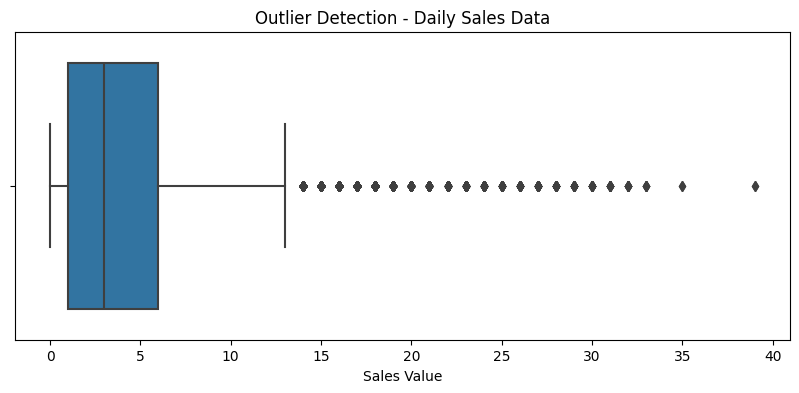

In [108]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=sales_traffic_data['Value_sales'])
plt.title('Outlier Detection - Daily Sales Data')
plt.xlabel('Sales Value')
plt.show()

In [109]:
Q1S = sales_traffic_data['Value_sales'].quantile(0.25)
Q3S = sales_traffic_data['Value_sales'].quantile(0.75)
IQRS = Q3S - Q1S 

In [112]:
sales_data_iqr = sales_traffic_data[(sales_traffic_data['Value_sales'] >= Q1S - 1.5 * IQRS) & (sales_traffic_data['Value_sales'] <= Q3S + 1.5 * IQRS)]

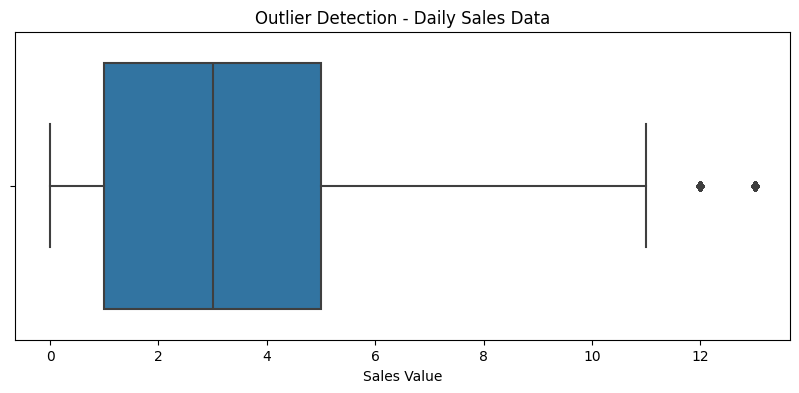

In [113]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=sales_data_iqr['Value_sales'])
plt.title('Outlier Detection - Daily Sales Data')
plt.xlabel('Sales Value')
plt.show()

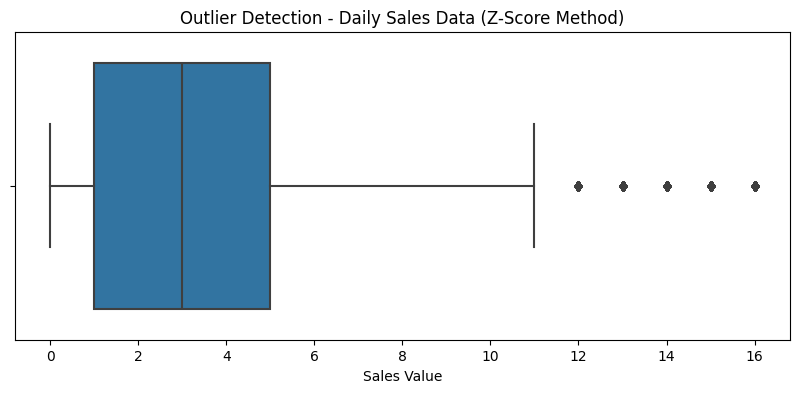

In [114]:
# Calculate the Z-scores for the sales data
sales_traffic_data['Z-Score'] = zscore(sales_traffic_data['Value_sales'])

# Filter out the outliers based on Z-score (threshold = 3 or -3)
sales_traffic_data_zscore = sales_traffic_data[sales_traffic_data['Z-Score'].abs() <= 3]

# Plot the boxplot for Z-score filtered data
plt.figure(figsize=(10, 4))
sns.boxplot(x=sales_traffic_data_zscore['Value_sales'])
plt.title('Outlier Detection - Daily Sales Data (Z-Score Method)')
plt.xlabel('Sales Value')
plt.show()

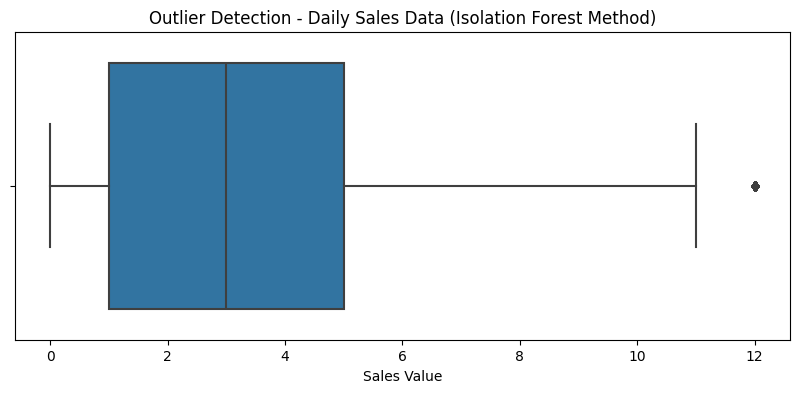

In [137]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05)  # Adjust contamination rate as needed

# Fit the model on the sales data and predict outliers (1 = inlier, -1 = outlier)
sales_traffic_data['Outlier_sales'] = iso_forest.fit_predict(sales_traffic_data[['Value_sales']])

# Filter the data by removing outliers
sales_traffic_data_iso = sales_traffic_data[sales_traffic_data['Outlier_sales'] == 1]

# Plot the boxplot for Isolation Forest filtered data
plt.figure(figsize=(10, 4))
sns.boxplot(x=sales_traffic_data_iso['Value_sales'])
plt.title('Outlier Detection - Daily Sales Data (Isolation Forest Method)')
plt.xlabel('Sales Value')
plt.show()

In [116]:
sales_traffic_data.describe()

,Value_sales,Value_traffic,is_holiday,Z-Score,Outlier
count,67110.000000,67110.000000,67110.000000,6.711000e+04,67110.000000
mean,3.927239,815.641425,0.066622,1.948143e-17,0.905409
std,4.254257,100.291097,0.249368,1.000007e+00,0.424543
min,0.000000,0.000000,0.000000,-9.231385e-01,-1.000000
25%,1.000000,754.000000,0.000000,-6.880780e-01,1.000000
50%,3.000000,793.000000,0.000000,-2.179572e-01,1.000000
75%,6.000000,851.000000,0.000000,4.872241e-01,1.000000
max,39.000000,6435.000000,1.000000,8.244219e+00,1.000000


In [117]:
sales_data_iqr.describe()

,Value_sales,Value_traffic,is_holiday
count,64623.000000,64623.000000,64623.000000
mean,3.390248,810.888646,0.067050
std,3.219752,92.557013,0.250111
min,0.000000,0.000000,0.000000
25%,1.000000,753.000000,0.000000
50%,3.000000,791.000000,0.000000
75%,5.000000,847.000000,0.000000
max,13.000000,6435.000000,1.000000


In [118]:
sales_data_filtered_zscore.describe()

,Date,Value,Z-Score
count,57366,57366.000000,57366.000000
mean,2022-09-04 16:24:06.658299392,3.915734,-0.072649
min,2021-01-01 10:00:00,0.000000,-1.036951
25%,2021-11-03 09:07:30,1.000000,-0.790688
50%,2022-09-05 15:22:30,3.000000,-0.298161
75%,2023-07-07 18:26:15,6.000000,0.440630
max,2024-05-06 21:00:00,16.000000,2.903264
std,NaN,3.395499,0.836187


In [139]:
sales_traffic_data_iso.describe()

,Value_sales,Value_traffic,is_holiday,Z-Score,Outlier,Outlier_sales
count,63936.000000,63936.000000,63936.000000,63936.000000,63936.000000,63936.0
mean,3.286990,810.231872,0.067192,-0.053939,0.918012,1.0
std,3.078187,91.838256,0.250357,0.915724,0.396556,0.0
min,0.000000,0.000000,0.000000,-8.132801,-1.000000,1.0
25%,1.000000,753.000000,0.000000,-0.624601,1.000000,1.0
50%,3.000000,790.000000,0.000000,-0.255672,1.000000,1.0
75%,5.000000,846.000000,0.000000,0.302707,1.000000,1.0
max,12.000000,6435.000000,1.000000,56.030900,1.000000,1.0


In [140]:
sales_traffic_data_iso

,Date,Value_sales,Value_traffic,is_holiday,Z-Score,Outlier,Outlier_sales
0,2023-02-13 08:15:49,0.0,758,0,-0.574745,1,1
1,2023-02-13 08:15:49,0.0,718,0,-0.973587,1,1
2,2023-02-13 08:15:49,0.0,758,0,-0.574745,1,1
3,2023-02-13 08:15:49,0.0,834,0,0.183054,1,1
4,2023-02-13 08:15:49,0.0,691,0,-1.242806,1,1
...,...,...,...,...,...,...,...
67105,2023-01-01 12:00:00,7.0,821,0,0.053431,1,1
67106,2023-01-01 11:45:00,5.0,810,0,-0.056251,1,1
67107,2023-01-01 11:30:00,2.0,798,0,-0.175904,1,1
67108,2023-01-01 11:15:00,3.0,729,0,-0.863906,1,1


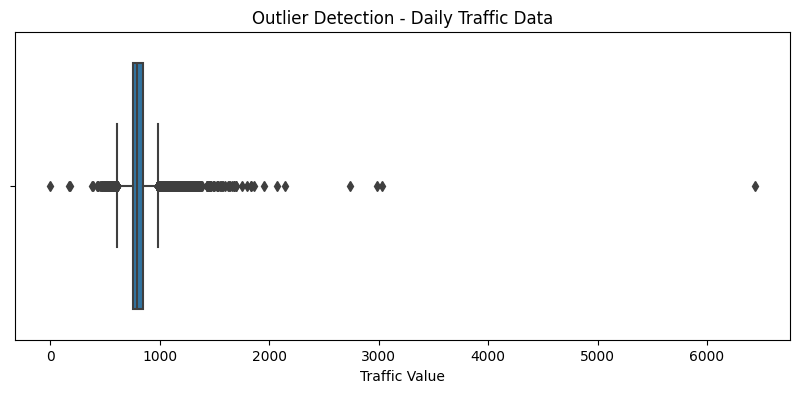

In [141]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=sales_traffic_data_iso['Value_traffic'])
plt.title('Outlier Detection - Daily Traffic Data')
plt.xlabel('Traffic Value')
plt.show()

In [142]:
Q1T = sales_traffic_data_iso['Value_traffic'].quantile(0.25)
Q3T = sales_traffic_data_iso['Value_traffic'].quantile(0.75)
IQRT = Q3T - Q1T 

In [143]:
traffic_data_iqr = sales_traffic_data_iso[(sales_traffic_data_iso['Value_traffic'] >= Q1T - 1.5 * IQRT) & (sales_traffic_data_iso['Value_traffic'] <= Q3T + 1.5 * IQRT)]

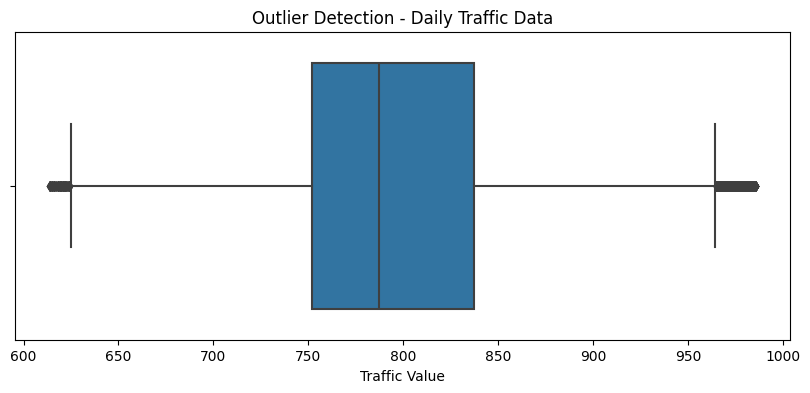

In [145]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=traffic_data_iqr['Value_traffic'])
plt.title('Outlier Detection - Daily Traffic Data')
plt.xlabel('Traffic Value')
plt.show()

C:\Users\Chamodi\AppData\Local\Temp\ipykernel_24120\1440756245.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_traffic_data_iso['Z-Score'] = zscore(sales_traffic_data_iso['Value_traffic'])


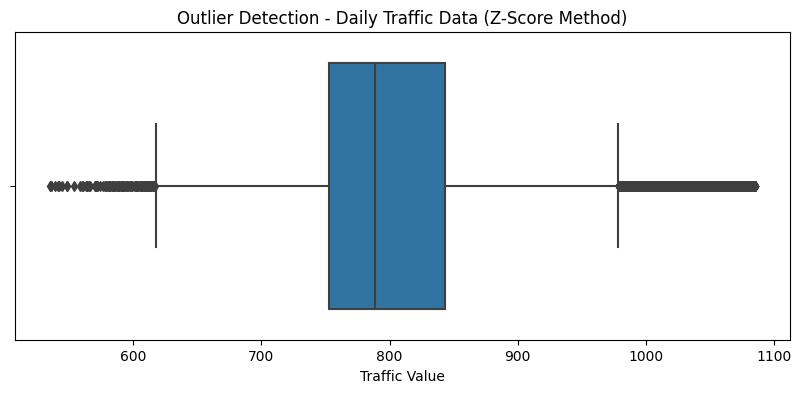

In [146]:
# Calculate the Z-scores for the traffic data
sales_traffic_data_iso['Z-Score'] = zscore(sales_traffic_data_iso['Value_traffic'])

# Filter out the outliers based on Z-score (threshold = 3 or -3)
traffic_data_filtered_zscore = sales_traffic_data_iso[sales_traffic_data_iso['Z-Score'].abs() <= 3]

# Plot the boxplot for Z-score filtered data
plt.figure(figsize=(10, 4))
sns.boxplot(x=traffic_data_filtered_zscore['Value_traffic'])
plt.title('Outlier Detection - Daily Traffic Data (Z-Score Method)')
plt.xlabel('Traffic Value')
plt.show()

C:\Users\Chamodi\AppData\Local\Temp\ipykernel_24120\2335918606.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_traffic_data_iso['Outlier_traffic'] = iso_forest.fit_predict(sales_traffic_data_iso[['Value_traffic']])


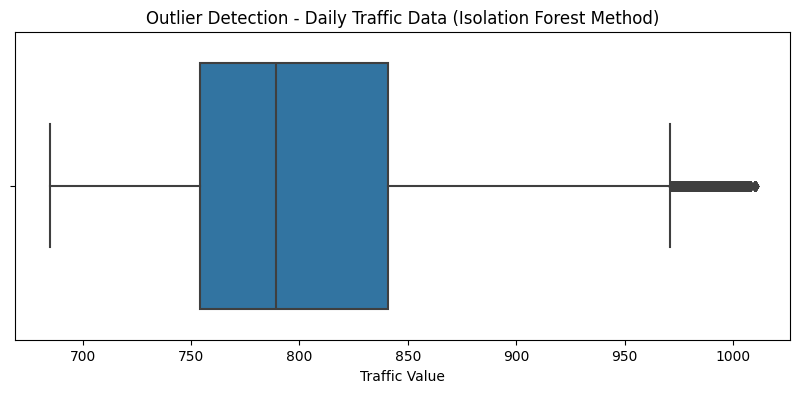

In [154]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05)  # Adjust contamination rate as needed

# Fit the model on the traffic data and predict outliers (1 = inlier, -1 = outlier)
sales_traffic_data_iso['Outlier_traffic'] = iso_forest.fit_predict(sales_traffic_data_iso[['Value_traffic']])

# Filter the data by removing outliers
sales_traffic_data_iso_all = sales_traffic_data_iso[sales_traffic_data_iso['Outlier_traffic'] == 1]

# Plot the boxplot for Isolation Forest filtered data
plt.figure(figsize=(10, 4))
sns.boxplot(x=sales_traffic_data_iso_all['Value_traffic'])
plt.title('Outlier Detection - Daily Traffic Data (Isolation Forest Method)')
plt.xlabel('Traffic Value')
plt.show()

In [148]:
sales_traffic_data.describe()

,Value_sales,Value_traffic,is_holiday,Z-Score,Outlier,Outlier_sales
count,67110.000000,67110.000000,67110.000000,6.711000e+04,67110.000000,67110.000000
mean,3.927239,815.641425,0.066622,2.405533e-16,0.899985,0.905409
std,4.254257,100.291097,0.249368,1.000007e+00,0.435924,0.424543
min,0.000000,0.000000,0.000000,-8.132801e+00,-1.000000,-1.000000
25%,1.000000,754.000000,0.000000,-6.146297e-01,1.000000,1.000000
50%,3.000000,793.000000,0.000000,-2.257588e-01,1.000000,1.000000
75%,6.000000,851.000000,0.000000,3.525621e-01,1.000000,1.000000
max,39.000000,6435.000000,1.000000,5.603090e+01,1.000000,1.000000


In [149]:
traffic_data_iqr.describe()

,Value_sales,Value_traffic,is_holiday,Z-Score,Outlier,Outlier_sales
count,61049.000000,61049.000000,61049.00000,61049.000000,61049.000000,61049.0
mean,3.219922,798.641894,0.06824,-0.169503,0.965765,1.0
std,3.021933,64.155792,0.25216,0.639701,0.259420,0.0
min,0.000000,614.000000,0.00000,-2.010577,-1.000000,1.0
25%,1.000000,752.000000,0.00000,-0.634572,1.000000,1.0
50%,3.000000,787.000000,0.00000,-0.285585,1.000000,1.0
75%,5.000000,837.000000,0.00000,0.212967,1.000000,1.0
max,12.000000,985.000000,1.00000,1.688683,1.000000,1.0


In [150]:
traffic_data_filtered_zscore.describe()

,Value_sales,Value_traffic,is_holiday,Z-Score,Outlier,Outlier_sales
count,63015.000000,63015.000000,63015.000000,63015.000000,63015.000000,63015.0
mean,3.263080,804.927192,0.067666,-0.057762,0.946045,1.0
std,3.056157,74.597275,0.251175,0.812274,0.324039,0.0
min,0.000000,535.000000,0.000000,-2.996943,-1.000000,1.0
25%,1.000000,753.000000,0.000000,-0.623186,1.000000,1.0
50%,3.000000,789.000000,0.000000,-0.231189,1.000000,1.0
75%,5.000000,843.000000,0.000000,0.356805,1.000000,1.0
max,12.000000,1085.000000,1.000000,2.991893,1.000000,1.0


In [155]:
sales_traffic_data_iso_all.describe()

,Value_sales,Value_traffic,is_holiday,Z-Score,Outlier,Outlier_sales,Outlier_traffic
count,60756.000000,60756.000000,60756.000000,60756.000000,60756.000000,60756.0,60756.0
mean,3.240092,803.056192,0.068108,-0.078135,0.997794,1.0,1.0
std,3.036076,65.287444,0.251934,0.710902,0.066380,0.0,0.0
min,0.000000,685.000000,0.000000,-1.363624,-1.000000,1.0,1.0
25%,1.000000,754.000000,0.000000,-0.612297,1.000000,1.0,1.0
50%,3.000000,789.000000,0.000000,-0.231189,1.000000,1.0,1.0
75%,5.000000,841.000000,0.000000,0.335028,1.000000,1.0,1.0
max,12.000000,1010.000000,1.000000,2.175234,1.000000,1.0,1.0


In [133]:
sales_traffic_data.head(100)

,Date,Value_sales,Value_traffic,is_holiday,Z-Score,Outlier
0,2023-02-13 08:15:49,0.0,758,0,-0.574745,1
1,2023-02-13 08:15:49,0.0,718,0,-0.973587,1
2,2023-02-13 08:15:49,0.0,758,0,-0.574745,1
3,2023-02-13 08:15:49,0.0,834,0,0.183054,1
4,2023-02-13 08:15:49,0.0,691,0,-1.242806,1
...,...,...,...,...,...,...
95,2024-12-29 18:00:00,0.0,860,0,0.442302,1
96,2024-12-29 17:45:00,0.0,879,0,0.631751,1
97,2024-12-29 17:30:00,0.0,736,0,-0.794109,1
98,2024-12-29 17:15:00,0.0,706,0,-1.093240,1


In [156]:
# === 8. Save Cleaned Data ===
sales_traffic_data_iso_all.to_csv('../Required Data/outlier_handled_file.csv')

In [157]:
sales_traffic_data_iso_all

,Date,Value_sales,Value_traffic,is_holiday,Z-Score,Outlier,Outlier_sales,Outlier_traffic
0,2023-02-13 08:15:49,0.0,758,0,-0.568742,1,1,1
1,2023-02-13 08:15:49,0.0,718,0,-1.004294,1,1,1
2,2023-02-13 08:15:49,0.0,758,0,-0.568742,1,1,1
3,2023-02-13 08:15:49,0.0,834,0,0.258806,1,1,1
4,2023-02-13 08:15:49,0.0,691,0,-1.298291,1,1,1
...,...,...,...,...,...,...,...,...
67105,2023-01-01 12:00:00,7.0,821,0,0.117252,1,1,1
67106,2023-01-01 11:45:00,5.0,810,0,-0.002525,1,1,1
67107,2023-01-01 11:30:00,2.0,798,0,-0.133190,1,1,1
67108,2023-01-01 11:15:00,3.0,729,0,-0.884517,1,1,1


In [161]:
# === 6. Time Series Decomposition for 'Value_sales' ===
decomposition_sales = seasonal_decompose(sales_traffic_data_iso_all['Value_sales'], model='additive', period=7)

# === 6. Time Series Decomposition for 'Value_traffic' ===
decomposition_traffic = seasonal_decompose(sales_traffic_data_iso_all['Value_traffic'], model='additive', period=7)

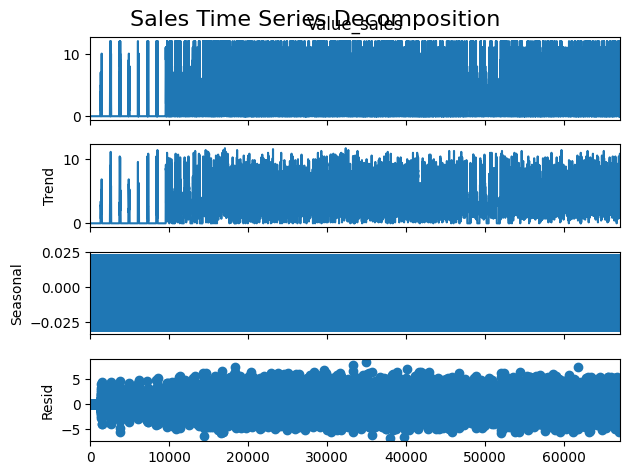

In [162]:
# Plot the decomposition for sales
decomposition_sales.plot()
plt.suptitle("Sales Time Series Decomposition", fontsize=16)
plt.show()

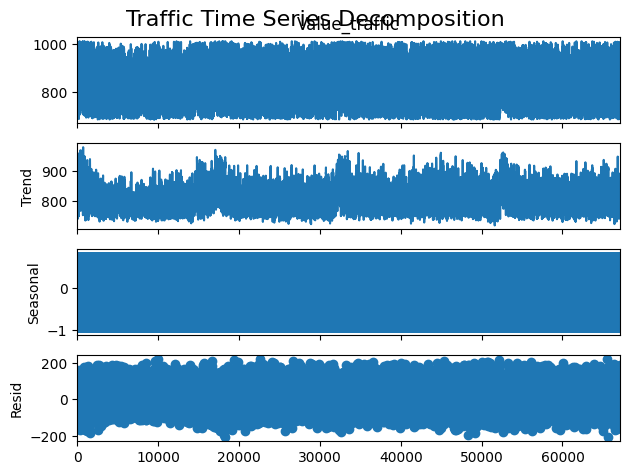

In [163]:
# Plot the decomposition for traffic
decomposition_traffic.plot()
plt.suptitle("Traffic Time Series Decomposition", fontsize=16)
plt.show()

In [166]:
correlation = sales_traffic_data_iso_all['Value_sales'].corr(sales_traffic_data_iso_all['Value_traffic'])
print(f"Correlation between sales and traffic: {correlation:.2f}")

Correlation between sales and traffic: 0.17


In [168]:
cross_corr = sales_traffic_data_iso_all['Value_sales'].corr(sales_traffic_data_iso_all['Value_traffic'].shift(-1))
print(f"Cross-correlation between sales and traffic with a lag of 1: {cross_corr:.2f}")

Cross-correlation between sales and traffic with a lag of 1: 0.15


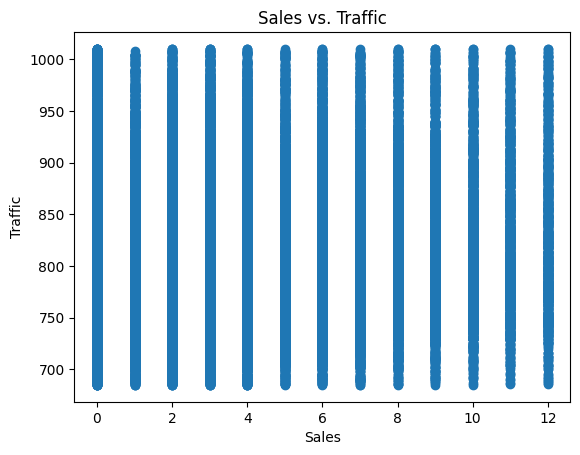

In [167]:
# Scatter plot of sales vs. traffic
plt.scatter(sales_traffic_data_iso_all['Value_sales'], sales_traffic_data_iso_all['Value_traffic'])
plt.title("Sales vs. Traffic")
plt.xlabel("Sales")
plt.ylabel("Traffic")
plt.show()

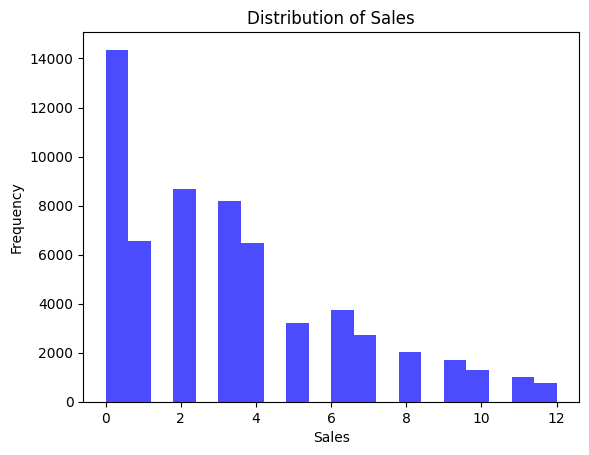

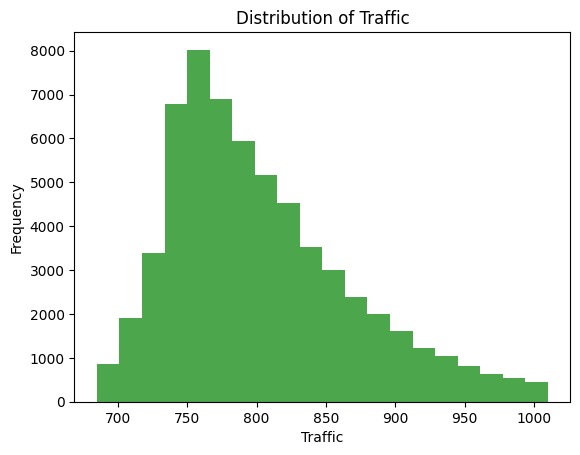

In [169]:
# Histogram for 'Sales'
plt.hist(sales_traffic_data_iso_all['Value_sales'], bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

# Histogram for 'Traffic'
plt.hist(sales_traffic_data_iso_all['Value_traffic'], bins=20, color='green', alpha=0.7)
plt.title("Distribution of Traffic")
plt.xlabel("Traffic")
plt.ylabel("Frequency")
plt.show()

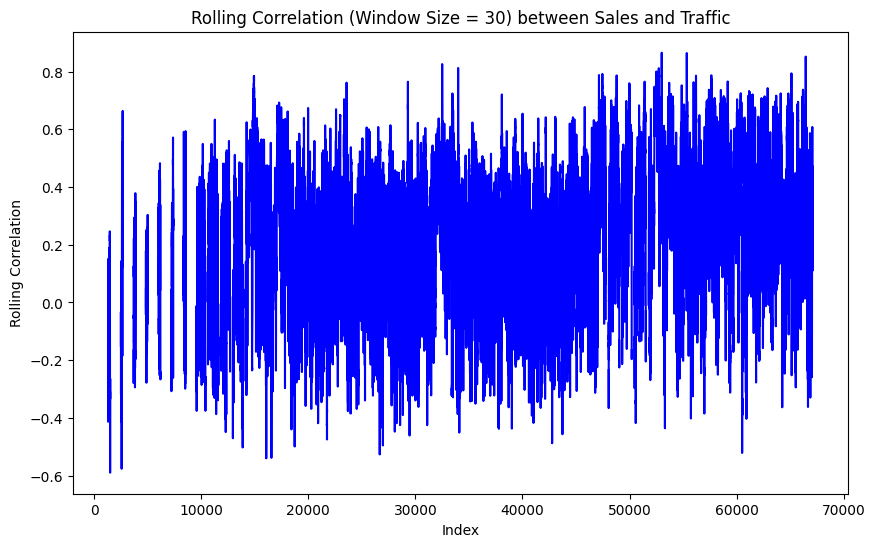

In [170]:
# Define the rolling window size (for example, a 30-day window)
window_size = 30

# Calculate the rolling correlation between 'Value_sales' and 'Value_traffic'
rolling_corr = sales_traffic_data_iso_all['Value_sales'].rolling(window=window_size).corr(sales_traffic_data_iso_all['Value_traffic'])

# Plot the rolling correlation
plt.figure(figsize=(10, 6))
plt.plot(rolling_corr, color='blue')
plt.title(f"Rolling Correlation (Window Size = {window_size}) between Sales and Traffic")
plt.xlabel("Index")
plt.ylabel("Rolling Correlation")
plt.show()

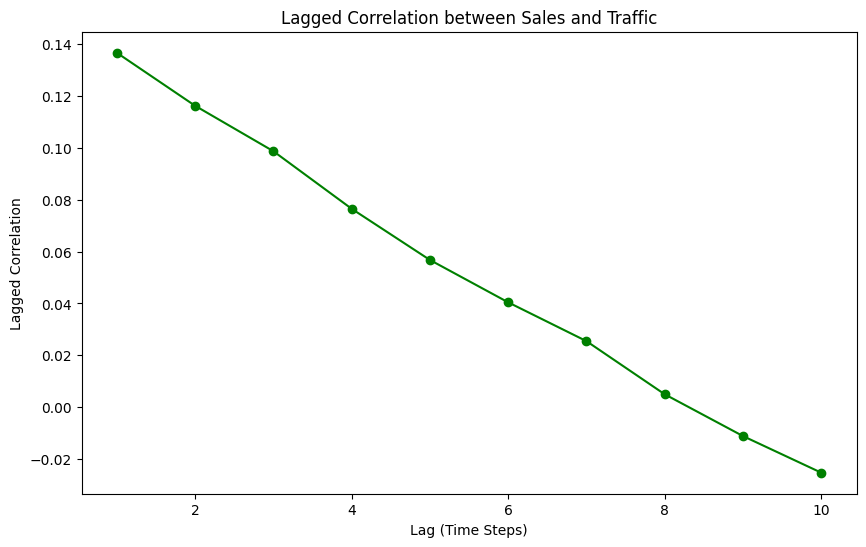

In [171]:
# Define the lag values (e.g., lag between 1 and 10 time steps)
lags = range(1, 11)

# Store the lagged correlations
lagged_correlations = []

# Calculate lagged correlations for each lag
for lag in lags:
    lagged_corr = sales_traffic_data_iso_all['Value_sales'].corr(sales_traffic_data_iso_all['Value_traffic'].shift(lag))
    lagged_correlations.append(lagged_corr)

# Plot the lagged correlation results
plt.figure(figsize=(10, 6))
plt.plot(lags, lagged_correlations, marker='o', color='green')
plt.title("Lagged Correlation between Sales and Traffic")
plt.xlabel("Lag (Time Steps)")
plt.ylabel("Lagged Correlation")
plt.show()

In [175]:
# === 5. Statistical Summary ===
print("\nDaily Sales & traffic Data Summary:")
print(sales_traffic_data_iso_all['Value_sales'].describe())
print(sales_traffic_data_iso_all['Value_traffic'].describe())


Daily Sales & traffic Data Summary:
count    60756.000000
mean         3.240092
std          3.036076
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max         12.000000
Name: Value_sales, dtype: float64
count    60756.000000
mean       803.056192
std         65.287444
min        685.000000
25%        754.000000
50%        789.000000
75%        841.000000
max       1010.000000
Name: Value_traffic, dtype: float64


In [176]:
nan_per_column = sales_traffic_data_iso_all.isna().sum()
print("\nNaN values per column:")
print(nan_per_column)


NaN values per column:
Date               0
Value_sales        0
Value_traffic      0
is_holiday         0
Z-Score            0
Outlier            0
Outlier_sales      0
Outlier_traffic    0
dtype: int64


In [177]:
#save the cleaned dataset to a csv file
output_file_path = "../Required Data/final_dataset.csv"
sales_traffic_data_iso_all.to_csv(output_file_path, index=False)